https://analyticsindiamag.com/pseudo-labelling-a-guide-to-semi-supervised-learning/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from contextlib import contextmanager
import time
import os
import sys
import math
import time
import pickle
import psutil
import random
from pathlib import Path


from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve,  KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

import missingno

import seaborn as sns


import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

In [2]:
# ------------------------------------------------------------------------------
# Utilities
# ------------------------------------------------------------------------------
@contextmanager
def timer(name: str):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    try:
        yield
    finally:
        m1 = p.memory_info()[0] / 2. ** 30
        delta = m1 - m0
        sign = '+' if delta >= 0 else '-'
        delta = math.fabs(delta)
        print(f"[{m1:.1f}GB({sign}{delta:.1f}GB): {time.time() - t0:.3f}sec] {name}", file=sys.stderr)


def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


def score_log(df: pd.DataFrame, seed: int, num_fold: int, model_name: str, cv: float):
    score_dict = {'date': datetime.now(), 'seed': seed, 'fold': num_fold, 'model': model_name, 'cv': cv}
    # noinspection PyTypeChecker
    df = pd.concat([df, pd.DataFrame.from_dict([score_dict])])
    df.to_csv(LOG_PATH / f"model_score_{model_name}.csv", index=False)
    return df

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

In [4]:
def SingleTraining(classifier, features, target,  title=None, test_size=0.2, random_state=0):
    
    with timer(title):
        X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        test_size=test_size, 
                                                        random_state=random_state)
        classifier.fit(X_train, y_train)
        preds = classifier.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        print("AUC: {0:.8f}".format(score))
        
        return score, preds
        
def cross_validation(classifier, X_train, y_train, title=None, cv=10, n_jobs=-1):
    with timer(title):
        scores = cross_val_score(classifier, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=n_jobs)
        print("AUC Mean: {0:.8f} / Std: {1:.8f}".format(scores.mean(), scores.std()))
        
        return scores

# Loading Train and Test Data

In [5]:
train = pd.read_csv("./input/train.csv", index_col='id')
test = pd.read_csv('./input/test.csv', index_col='id')

In [6]:
cat_cols = ['cat'+str(i) for i in range(19)]
cont_cols = ['cont'+str(i) for i in range(11)]
features = cat_cols + cont_cols

# Categorical Feature LabelEncoding

In [7]:
data = pd.concat([train, test])

In [8]:
for cat in cat_cols:
    data[cat] = pd.factorize(data[cat])[0]

In [9]:
test = data[data['target'].isnull()]
train = data[~data['target'].isnull()]

# Features and Target separation

In [10]:
train['target'] = train['target'].astype('int64')
target = train.pop('target')

# Model : LightGBM (default)

In [11]:
clf_cv_list = {}

In [22]:
clf_cv_list

{'lgbm_clf': array([0.89075255, 0.88942784, 0.89036058, 0.88838181, 0.89071987,
        0.88913751, 0.88597703, 0.88814562, 0.89039929, 0.88594597]),
 'cb_clf': array([0.89408289, 0.89410621, 0.89418404, 0.89271492, 0.89432617,
        0.8928168 , 0.89067053, 0.8920148 , 0.89460149, 0.89046103]),
 'rf_clf': array([0.88407571, 0.88399151, 0.88533596, 0.88365678, 0.88592181,
        0.8841951 , 0.88076462, 0.88439553, 0.88453123, 0.88141661])}

In [22]:
lgbm_clf = LGBMClassifier()
score, preds = SingleTraining(lgbm_clf, train, target,  title='LGBM', test_size=0.2, random_state=0)

AUC: 0.88695314


[0.7GB(+0.1GB): 16.468sec] LGBM


In [12]:
lgbm_clf = LGBMClassifier()
lgbm_scores = cross_validation(lgbm_clf, train, target, title='LGBM', cv=10)

AUC Mean: 0.88892481 / Std: 0.00171935


[0.5GB(+0.0GB): 10.731sec] LGBM


In [13]:
clf_cv_list["lgbm_clf"] = lgbm_scores

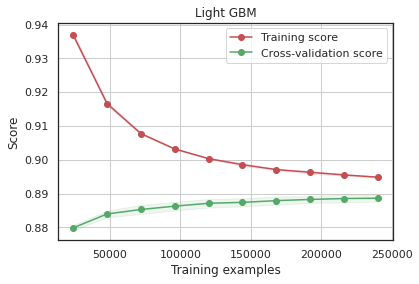

[0.6GB(+0.0GB): 28.895sec] Light GBM (default)


In [24]:
with timer("Light GBM (default)"):
    X_train, y_train = train, target
    plot_learning_curve(lgbm_clf, 'Light GBM', X_train, y_train, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 2. CatBoost

In [17]:
cb_clf = CatBoostClassifier()
score, preds = SingleTraining(cb_clf, train, target,  title='CatBoost', test_size=0.2, random_state=0)

Learning rate set to 0.106975
0:	learn: 0.6226569	total: 85.2ms	remaining: 1m 25s
1:	learn: 0.5662697	total: 114ms	remaining: 56.8s
2:	learn: 0.5257482	total: 139ms	remaining: 46.2s
3:	learn: 0.4952675	total: 158ms	remaining: 39.3s
4:	learn: 0.4714173	total: 179ms	remaining: 35.6s
5:	learn: 0.4535853	total: 204ms	remaining: 33.8s
6:	learn: 0.4376939	total: 242ms	remaining: 34.3s
7:	learn: 0.4266865	total: 272ms	remaining: 33.8s
8:	learn: 0.4170071	total: 300ms	remaining: 33.1s
9:	learn: 0.4098802	total: 323ms	remaining: 32s
10:	learn: 0.4040619	total: 350ms	remaining: 31.5s
11:	learn: 0.4002557	total: 369ms	remaining: 30.4s
12:	learn: 0.3958632	total: 390ms	remaining: 29.6s
13:	learn: 0.3924076	total: 415ms	remaining: 29.3s
14:	learn: 0.3890790	total: 448ms	remaining: 29.4s
15:	learn: 0.3866434	total: 476ms	remaining: 29.3s
16:	learn: 0.3846816	total: 498ms	remaining: 28.8s
17:	learn: 0.3827952	total: 528ms	remaining: 28.8s
18:	learn: 0.3811524	total: 559ms	remaining: 28.9s
19:	learn: 

169:	learn: 0.3495934	total: 4.52s	remaining: 22.1s
170:	learn: 0.3495188	total: 4.55s	remaining: 22.1s
171:	learn: 0.3494446	total: 4.57s	remaining: 22s
172:	learn: 0.3493409	total: 4.59s	remaining: 22s
173:	learn: 0.3492580	total: 4.62s	remaining: 21.9s
174:	learn: 0.3491934	total: 4.64s	remaining: 21.9s
175:	learn: 0.3491109	total: 4.66s	remaining: 21.8s
176:	learn: 0.3490589	total: 4.68s	remaining: 21.8s
177:	learn: 0.3489725	total: 4.7s	remaining: 21.7s
178:	learn: 0.3488717	total: 4.72s	remaining: 21.7s
179:	learn: 0.3488029	total: 4.77s	remaining: 21.7s
180:	learn: 0.3487319	total: 4.79s	remaining: 21.7s
181:	learn: 0.3486201	total: 4.82s	remaining: 21.7s
182:	learn: 0.3485527	total: 4.85s	remaining: 21.7s
183:	learn: 0.3484586	total: 4.88s	remaining: 21.6s
184:	learn: 0.3483735	total: 4.9s	remaining: 21.6s
185:	learn: 0.3482964	total: 4.92s	remaining: 21.5s
186:	learn: 0.3482147	total: 4.94s	remaining: 21.5s
187:	learn: 0.3481472	total: 4.97s	remaining: 21.5s
188:	learn: 0.3480

334:	learn: 0.3391734	total: 8.62s	remaining: 17.1s
335:	learn: 0.3391224	total: 8.65s	remaining: 17.1s
336:	learn: 0.3390639	total: 8.68s	remaining: 17.1s
337:	learn: 0.3390087	total: 8.71s	remaining: 17.1s
338:	learn: 0.3389821	total: 8.73s	remaining: 17s
339:	learn: 0.3389309	total: 8.75s	remaining: 17s
340:	learn: 0.3388798	total: 8.77s	remaining: 17s
341:	learn: 0.3388299	total: 8.79s	remaining: 16.9s
342:	learn: 0.3387843	total: 8.82s	remaining: 16.9s
343:	learn: 0.3387346	total: 8.85s	remaining: 16.9s
344:	learn: 0.3386738	total: 8.87s	remaining: 16.8s
345:	learn: 0.3386278	total: 8.89s	remaining: 16.8s
346:	learn: 0.3385746	total: 8.92s	remaining: 16.8s
347:	learn: 0.3385064	total: 8.94s	remaining: 16.7s
348:	learn: 0.3384498	total: 8.96s	remaining: 16.7s
349:	learn: 0.3384093	total: 8.99s	remaining: 16.7s
350:	learn: 0.3383630	total: 9.01s	remaining: 16.7s
351:	learn: 0.3383022	total: 9.04s	remaining: 16.6s
352:	learn: 0.3382177	total: 9.07s	remaining: 16.6s
353:	learn: 0.3381

494:	learn: 0.3317049	total: 12.6s	remaining: 12.9s
495:	learn: 0.3316515	total: 12.7s	remaining: 12.9s
496:	learn: 0.3316042	total: 12.7s	remaining: 12.8s
497:	learn: 0.3315734	total: 12.7s	remaining: 12.8s
498:	learn: 0.3315325	total: 12.7s	remaining: 12.8s
499:	learn: 0.3315078	total: 12.8s	remaining: 12.8s
500:	learn: 0.3314684	total: 12.8s	remaining: 12.7s
501:	learn: 0.3314324	total: 12.8s	remaining: 12.7s
502:	learn: 0.3314002	total: 12.8s	remaining: 12.7s
503:	learn: 0.3313614	total: 12.8s	remaining: 12.6s
504:	learn: 0.3313116	total: 12.9s	remaining: 12.6s
505:	learn: 0.3312599	total: 12.9s	remaining: 12.6s
506:	learn: 0.3312087	total: 12.9s	remaining: 12.6s
507:	learn: 0.3311673	total: 13s	remaining: 12.5s
508:	learn: 0.3311310	total: 13s	remaining: 12.5s
509:	learn: 0.3310930	total: 13s	remaining: 12.5s
510:	learn: 0.3310536	total: 13s	remaining: 12.5s
511:	learn: 0.3310091	total: 13s	remaining: 12.4s
512:	learn: 0.3309802	total: 13.1s	remaining: 12.4s
513:	learn: 0.3309457	

658:	learn: 0.3252290	total: 16.7s	remaining: 8.63s
659:	learn: 0.3252046	total: 16.7s	remaining: 8.6s
660:	learn: 0.3251739	total: 16.7s	remaining: 8.58s
661:	learn: 0.3251333	total: 16.8s	remaining: 8.55s
662:	learn: 0.3250913	total: 16.8s	remaining: 8.53s
663:	learn: 0.3250638	total: 16.8s	remaining: 8.5s
664:	learn: 0.3250273	total: 16.8s	remaining: 8.47s
665:	learn: 0.3249985	total: 16.8s	remaining: 8.44s
666:	learn: 0.3249730	total: 16.9s	remaining: 8.41s
667:	learn: 0.3249324	total: 16.9s	remaining: 8.39s
668:	learn: 0.3248861	total: 16.9s	remaining: 8.36s
669:	learn: 0.3248468	total: 16.9s	remaining: 8.34s
670:	learn: 0.3248050	total: 17s	remaining: 8.31s
671:	learn: 0.3247807	total: 17s	remaining: 8.28s
672:	learn: 0.3247370	total: 17s	remaining: 8.26s
673:	learn: 0.3246865	total: 17s	remaining: 8.23s
674:	learn: 0.3246368	total: 17s	remaining: 8.2s
675:	learn: 0.3245975	total: 17.1s	remaining: 8.18s
676:	learn: 0.3245597	total: 17.1s	remaining: 8.15s
677:	learn: 0.3245119	tot

818:	learn: 0.3195033	total: 20.5s	remaining: 4.54s
819:	learn: 0.3194669	total: 20.6s	remaining: 4.51s
820:	learn: 0.3194432	total: 20.6s	remaining: 4.49s
821:	learn: 0.3194068	total: 20.6s	remaining: 4.46s
822:	learn: 0.3193713	total: 20.6s	remaining: 4.44s
823:	learn: 0.3193484	total: 20.6s	remaining: 4.41s
824:	learn: 0.3193015	total: 20.7s	remaining: 4.38s
825:	learn: 0.3192672	total: 20.7s	remaining: 4.36s
826:	learn: 0.3192227	total: 20.7s	remaining: 4.33s
827:	learn: 0.3191879	total: 20.7s	remaining: 4.31s
828:	learn: 0.3191704	total: 20.8s	remaining: 4.28s
829:	learn: 0.3191330	total: 20.8s	remaining: 4.26s
830:	learn: 0.3191134	total: 20.8s	remaining: 4.24s
831:	learn: 0.3190783	total: 20.8s	remaining: 4.21s
832:	learn: 0.3190472	total: 20.9s	remaining: 4.18s
833:	learn: 0.3190173	total: 20.9s	remaining: 4.16s
834:	learn: 0.3189861	total: 20.9s	remaining: 4.13s
835:	learn: 0.3189482	total: 21s	remaining: 4.11s
836:	learn: 0.3189100	total: 21s	remaining: 4.09s
837:	learn: 0.31

983:	learn: 0.3140664	total: 24.6s	remaining: 400ms
984:	learn: 0.3140320	total: 24.6s	remaining: 375ms
985:	learn: 0.3139993	total: 24.7s	remaining: 350ms
986:	learn: 0.3139670	total: 24.7s	remaining: 325ms
987:	learn: 0.3139319	total: 24.7s	remaining: 300ms
988:	learn: 0.3139099	total: 24.7s	remaining: 275ms
989:	learn: 0.3138800	total: 24.8s	remaining: 250ms
990:	learn: 0.3138418	total: 24.8s	remaining: 225ms
991:	learn: 0.3138178	total: 24.8s	remaining: 200ms
992:	learn: 0.3137830	total: 24.8s	remaining: 175ms
993:	learn: 0.3137478	total: 24.9s	remaining: 150ms
994:	learn: 0.3137230	total: 24.9s	remaining: 125ms
995:	learn: 0.3136921	total: 24.9s	remaining: 100ms
996:	learn: 0.3136673	total: 24.9s	remaining: 75ms
997:	learn: 0.3136350	total: 24.9s	remaining: 50ms
998:	learn: 0.3136051	total: 25s	remaining: 25ms
999:	learn: 0.3135703	total: 25s	remaining: 0us
AUC: 0.89120023


[0.6GB(+0.1GB): 25.489sec] CatBoost


In [14]:
cb_clf = CatBoostClassifier()
cb_score = cross_validation(cb_clf, train, target, title='CatBoost', cv=10)

AUC Mean: 0.89299789 / Std: 0.00145189


[0.5GB(+0.0GB): 287.476sec] CatBoost


In [19]:
clf_cv_list["cb_clf"] = cb_score

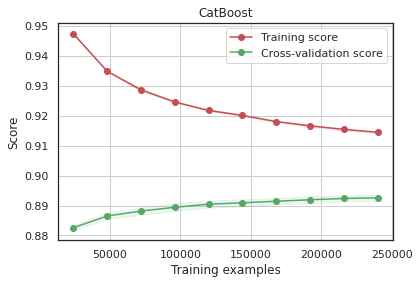

[0.6GB(+0.0GB): 896.091sec] CatBoost (default)


In [19]:
with timer("CatBoost (default)"):
    plot_learning_curve(cb_clf, 'CatBoost', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 3. Random Forest

In [12]:
rf_clf = RandomForestClassifier()
score, preds = SingleTraining(rf_clf, train, target,  title='Random Forest', test_size=0.2, random_state=0)

AUC: 0.88251609


[1.0GB(+0.5GB): 78.372sec] Random Forest


In [20]:
rf_clf = RandomForestClassifier()
rf_score = cross_validation(rf_clf, train, target, title='Random Forest', cv=10)

AUC Mean: 0.88382848 / Std: 0.00151413


[0.5GB(+0.0GB): 150.278sec] Random Forest


In [21]:
clf_cv_list["rf_clf"] = rf_score

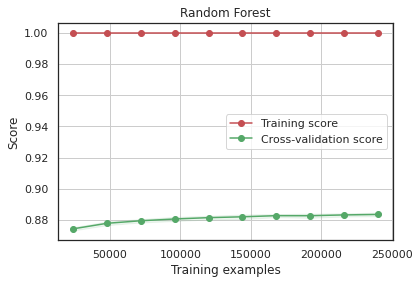

[0.5GB(+0.0GB): 358.428sec] Random Forest (default)


In [16]:
with timer("Random Forest (default)"):
    plot_learning_curve(rf_clf, 'Random Forest', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 4. XGBoost

In [26]:
xgb_clf = XGBClassifier()
score, preds = SingleTraining(xgb_clf, train, target,  title='XGBoost', test_size=0.2, random_state=0)

[15:24:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.88759257


[0.7GB(+0.1GB): 11.505sec] XGBoost


In [23]:
xgb_clf = XGBClassifier()
xgb_score = cross_validation(xgb_clf, train, target, title='XGBoost', cv=10)

AUC Mean: 0.88980441 / Std: 0.00153323


[0.5GB(+0.0GB): 192.927sec] XGBoost


In [24]:
clf_cv_list["xgb_clf"] = xgb_score

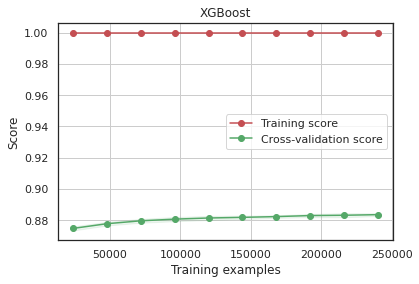

[0.7GB(+0.0GB): 350.707sec] XGBoost (default)


In [28]:
with timer("XGBoost (default)"):
    plot_learning_curve(rf_clf, 'XGBoost', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 5. Logistic Regression

In [31]:
lr_clf = LogisticRegression()
score, preds = SingleTraining(lr_clf, train, target,  title='Logistic Regression', test_size=0.2, random_state=0)

AUC: 0.85039010


[0.9GB(+0.1GB): 3.187sec] Logistic Regression


In [25]:
lr_clf = LogisticRegression()
lr_score = cross_validation(lr_clf, train, target, title='Logistic Regression', cv=10)

AUC Mean: 0.85260018 / Std: 0.00296361


[0.5GB(+0.0GB): 9.764sec] Logistic Regression


In [26]:
clf_cv_list["lr_clf"] = lr_score

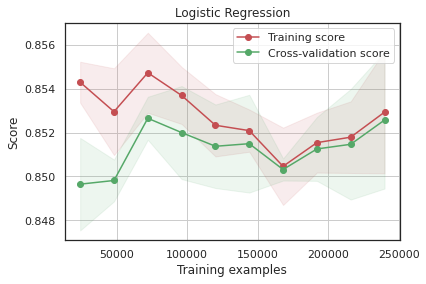

[0.9GB(+0.0GB): 23.247sec] Logistic Regression (default)


In [34]:
with timer("Logistic Regression (default)"):
    plot_learning_curve(lr_clf, 'Logistic Regression', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 6. Decision Tree

In [35]:
dt_clf = DecisionTreeClassifier()
score, preds = SingleTraining(dt_clf, train, target,  title='Decision Tree', test_size=0.2, random_state=0)

AUC: 0.70545366


[0.9GB(+0.1GB): 7.390sec] Decision Tree


In [27]:
dt_clf = DecisionTreeClassifier()
dt_score = cross_validation(dt_clf, train, target, title='Decision Tree', cv=10)

AUC Mean: 0.70973076 / Std: 0.00244304


[0.5GB(+0.0GB): 12.209sec] Decision Tree


In [28]:
clf_cv_list["dt_clf"] = dt_score

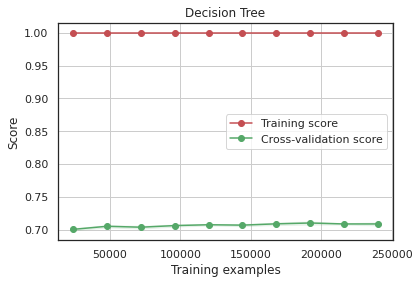

[0.8GB(+0.0GB): 28.244sec] Decision Tree (default)


In [38]:
with timer("Decision Tree (default)"):
    plot_learning_curve(dt_clf, 'Decision Tree', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 7. Extra Trees

In [39]:
ext_clf = ExtraTreesClassifier()
score, preds = SingleTraining(ext_clf, train, target,  title='Extra Tree', test_size=0.2, random_state=0)

AUC: 0.88220436


[2.0GB(+1.2GB): 38.546sec] Extra Tree


In [29]:
ext_clf = ExtraTreesClassifier()
ext_score = cross_validation(ext_clf, train, target, title='Extra Tree', cv=10)

AUC Mean: 0.88336588 / Std: 0.00192378


[0.5GB(+0.0GB): 89.638sec] Extra Tree


In [30]:
clf_cv_list["ext_clf"] = ext_score

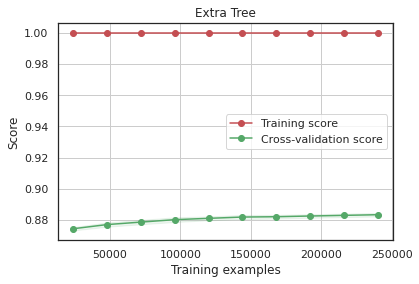

[0.8GB(+0.0GB): 243.590sec] Extra Tree (default)


In [43]:
with timer("Extra Tree (default)"):
    plot_learning_curve(ext_clf, 'Extra Tree', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 8. Gradient Boost

In [44]:
gb_clf = GradientBoostingClassifier()
score, preds = SingleTraining(gb_clf, train, target,  title='Gradient Boost', test_size=0.2, random_state=0)

AUC: 0.87848729


[0.9GB(+0.1GB): 126.138sec] Gradient Boost


In [31]:
gb_clf = GradientBoostingClassifier()
gb_score = cross_validation(gb_clf, train, target, title='Gradient Boost', cv=10)

AUC Mean: 0.88018668 / Std: 0.00195933


[0.5GB(+0.0GB): 271.654sec] Gradient Boost


In [32]:
clf_cv_list["gb_clf"] = gb_score

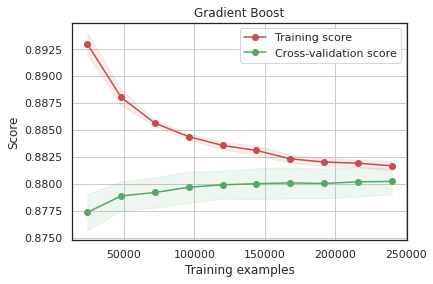

[0.8GB(+0.0GB): 563.149sec] Gradient Boost (default)


In [47]:
with timer("Gradient Boost (default)"):
    plot_learning_curve(gb_clf, 'Gradient Boost', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 9. AdaBoost

In [48]:
adb_clf = AdaBoostClassifier()
score, preds = SingleTraining(adb_clf, train, target,  title='AdaBoost', test_size=0.2, random_state=0)

AUC: 0.87360216


[0.9GB(+0.1GB): 27.246sec] AdaBoost


In [33]:
adb_clf = AdaBoostClassifier()
adb_score = cross_validation(adb_clf, train, target, title='AdaBoost', cv=10)

AUC Mean: 0.87511212 / Std: 0.00197673


[0.5GB(+0.0GB): 56.899sec] AdaBoost


In [34]:
clf_cv_list["adb_clf"] = adb_score

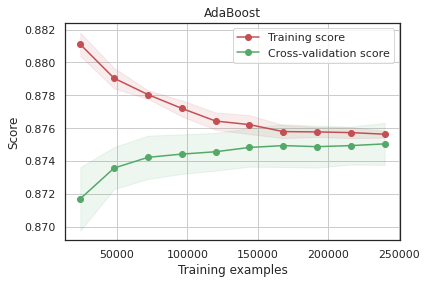

[0.9GB(+0.0GB): 135.081sec] AdaBoost (default)


In [51]:
with timer("AdaBoost (default)"):
    plot_learning_curve(adb_clf, 'AdaBoost', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 10. SVC

In [ ]:
svc_clf = SVC(probability=True)
score, preds = SingleTraining(svc_clf, train, target,  title='SVC', test_size=0.2, random_state=0)

In [ ]:
svc_clf = SVC()
svc_score = cross_validation(svc_clf, train, target, title='SVC', cv=10)

In [ ]:
clf_cv_list["svc_clf"] = svc_score

In [ ]:
with timer("SVC (default)"):
    plot_learning_curve(svc_clf, 'SVC', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 11. k-Nearest Neighbors

In [35]:
knn_clf = KNeighborsClassifier()
score, preds = SingleTraining(knn_clf, train, target,  title='kNN', test_size=0.2, random_state=0)

AUC: 0.79765775


[0.6GB(+0.1GB): 271.639sec] kNN


In [36]:
knn_clf = KNeighborsClassifier()
knn_score = cross_validation(knn_clf, train, target, title='kNN', cv=10)

AUC Mean: 0.80171285 / Std: 0.00197453


[0.5GB(-0.0GB): 483.593sec] kNN


In [37]:
clf_cv_list["knn_clf"] = knn_score

In [ ]:
with timer("kNN (default)"):
    plot_learning_curve(knn_clf, 'kNN', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## 12. Multiple Layer Perceptron

In [38]:
mlp_clf = MLPClassifier()
score, preds = SingleTraining(mlp_clf, train, target,  title='MLP', test_size=0.2, random_state=0)

AUC: 0.87673932


[0.6GB(+0.0GB): 167.346sec] MLP


In [40]:
mlp_clf = MLPClassifier()
mlp_score = cross_validation(mlp_clf, train, target, title='MLP', cv=10)

AUC Mean: 0.87854848 / Std: 0.00165596


[0.5GB(+0.0GB): 227.152sec] MLP


In [41]:
clf_cv_list["mlp_clf"] = mlp_score

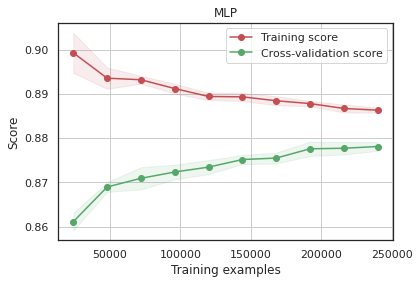

[0.5GB(+0.0GB): 634.825sec] MLP(default)


In [42]:
with timer("MLP(default)"):
    plot_learning_curve(mlp_clf, 'MLP', train, target, cv=5, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 10))

## Summary

In [43]:
clf_cv_list

{'lgbm_clf': array([0.89075255, 0.88942784, 0.89036058, 0.88838181, 0.89071987,
        0.88913751, 0.88597703, 0.88814562, 0.89039929, 0.88594597]),
 'cb_clf': array([0.89408289, 0.89410621, 0.89418404, 0.89271492, 0.89432617,
        0.8928168 , 0.89067053, 0.8920148 , 0.89460149, 0.89046103]),
 'rf_clf': array([0.88407571, 0.88399151, 0.88533596, 0.88365678, 0.88592181,
        0.8841951 , 0.88076462, 0.88439553, 0.88453123, 0.88141661]),
 'xgb_clf': array([0.89067864, 0.8902589 , 0.89108866, 0.88997934, 0.89133019,
        0.88977911, 0.88638014, 0.88961347, 0.89127614, 0.88765952]),
 'lr_clf': array([0.85611222, 0.85653884, 0.85314008, 0.84772539, 0.84997613,
        0.85160026, 0.84988356, 0.85452856, 0.85608587, 0.8504109 ]),
 'dt_clf': array([0.707916  , 0.7070448 , 0.70594129, 0.70875673, 0.71350937,
        0.70958215, 0.71262337, 0.7092106 , 0.71303654, 0.70968674]),
 'ext_clf': array([0.8840974 , 0.88368962, 0.88533379, 0.88138177, 0.88554336,
        0.88526012, 0.88014043

In [45]:
from numpy import array
clf_cv_list = {'lgbm_clf': array([0.89075255, 0.88942784, 0.89036058, 0.88838181, 0.89071987,
                    0.88913751, 0.88597703, 0.88814562, 0.89039929, 0.88594597]),
               'cb_clf': array([0.89408289, 0.89410621, 0.89418404, 0.89271492, 0.89432617,
                    0.8928168 , 0.89067053, 0.8920148 , 0.89460149, 0.89046103]),
               'rf_clf': array([0.88407571, 0.88399151, 0.88533596, 0.88365678, 0.88592181,
                    0.8841951 , 0.88076462, 0.88439553, 0.88453123, 0.88141661]),
               'xgb_clf': array([0.89067864, 0.8902589 , 0.89108866, 0.88997934, 0.89133019,
                    0.88977911, 0.88638014, 0.88961347, 0.89127614, 0.88765952]),
               'lr_clf': array([0.85611222, 0.85653884, 0.85314008, 0.84772539, 0.84997613,
                    0.85160026, 0.84988356, 0.85452856, 0.85608587, 0.8504109 ]),
               'dt_clf': array([0.707916  , 0.7070448 , 0.70594129, 0.70875673, 0.71350937,
                    0.70958215, 0.71262337, 0.7092106 , 0.71303654, 0.70968674]),
               'ext_clf': array([0.8840974 , 0.88368962, 0.88533379, 0.88138177, 0.88554336,
                    0.88526012, 0.88014043, 0.88345418, 0.88436292, 0.8803952 ]),
               'gb_clf': array([0.88326637, 0.88075704, 0.88136229, 0.87971971, 0.8819435 ,
                    0.8801431 , 0.87680053, 0.87947944, 0.88142984, 0.87696493]),
               'adb_clf': array([0.87845515, 0.87586617, 0.8771748 , 0.87398502, 0.87577616,
                    0.87405914, 0.8720237 , 0.87491723, 0.87664027, 0.87222353]),
               'knn_clf': array([0.80444487, 0.80512521, 0.80214374, 0.8021494 , 0.80330218,
                    0.80015435, 0.79888885, 0.8004599 , 0.80078033, 0.79967962]),
               'mlp_clf': array([0.88034869, 0.8803512 , 0.87932304, 0.87697157, 0.88070396,
                    0.87776065, 0.87577811, 0.87875434, 0.87908353, 0.87640967])}

In [47]:
cv_mean  = []
cv_std   = []
cv_name  = []
clf_name = {'lgbm_clf':'Light GBM', 'rf_clf':'Random Forest', 'dt_clf':'Decision Tree', 'knn_clf':'K-Neighbors', 'adb_clf':'AdaBoost', 
            'ext_clf':'Extra Tree', 'lr_clf':'Logistic Regression', 'mlp_clf':'MLP', 'cb_clf':'CatBoost',
            'xgb_clf':'XGBoost', 'gb_clf':'Gradient Boost', 'adb_clf':'AdaBoost'}
for clf in clf_cv_list.keys():
    cv = clf_cv_list[clf]
    cv_mean.append(np.mean(cv))
    cv_std.append(np.std(cv))
    cv_name.append(clf_name[clf])
    print("{0:25s}:{1} > {2:.3f}, {3:.5f}".format(clf_name[clf], np.round(cv,3), np.mean(cv), np.std(cv)))

Light GBM                :[0.891 0.889 0.89  0.888 0.891 0.889 0.886 0.888 0.89  0.886] > 0.889, 0.00172
CatBoost                 :[0.894 0.894 0.894 0.893 0.894 0.893 0.891 0.892 0.895 0.89 ] > 0.893, 0.00145
Random Forest            :[0.884 0.884 0.885 0.884 0.886 0.884 0.881 0.884 0.885 0.881] > 0.884, 0.00151
XGBoost                  :[0.891 0.89  0.891 0.89  0.891 0.89  0.886 0.89  0.891 0.888] > 0.890, 0.00153
Logistic Regression      :[0.856 0.857 0.853 0.848 0.85  0.852 0.85  0.855 0.856 0.85 ] > 0.853, 0.00296
Decision Tree            :[0.708 0.707 0.706 0.709 0.714 0.71  0.713 0.709 0.713 0.71 ] > 0.710, 0.00244
Extra Tree               :[0.884 0.884 0.885 0.881 0.886 0.885 0.88  0.883 0.884 0.88 ] > 0.883, 0.00192
Gradient Boost           :[0.883 0.881 0.881 0.88  0.882 0.88  0.877 0.879 0.881 0.877] > 0.880, 0.00196
AdaBoost                 :[0.878 0.876 0.877 0.874 0.876 0.874 0.872 0.875 0.877 0.872] > 0.875, 0.00198
K-Neighbors              :[0.804 0.805 0.802 0.802 0.80

In [48]:
cv_result = pd.DataFrame({"Algorithm":cv_name, "CrossValMeans":cv_mean, "CrossValerrors": cv_std})

In [51]:
cv_result_sorted = cv_result.sort_values(by='CrossValMeans', ascending=False)
cv_result_sorted

,Algorithm,CrossValMeans,CrossValerrors
1,CatBoost,0.892998,0.001452
3,XGBoost,0.889804,0.001533
0,Light GBM,0.888925,0.001719
2,Random Forest,0.883828,0.001514
6,Extra Tree,0.883366,0.001924
7,Gradient Boost,0.880187,0.001959
10,MLP,0.878548,0.001656
8,AdaBoost,0.875112,0.001977
4,Logistic Regression,0.852600,0.002964
9,K-Neighbors,0.801713,0.001975


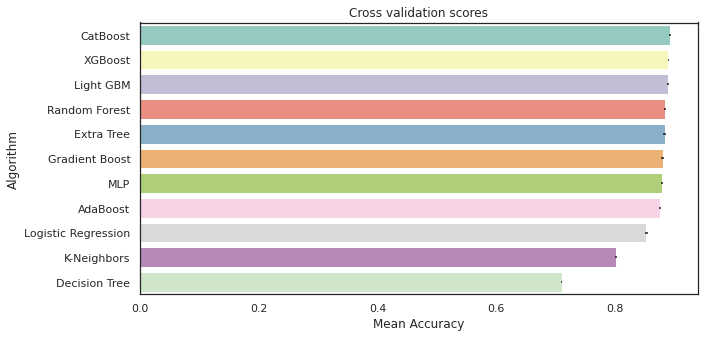

In [52]:
plt.figure(figsize=(10,5))
sns.barplot("CrossValMeans", "Algorithm", data = cv_result_sorted, 
            palette="Set3", orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")
plt.show()

# Confusion Matrix and Related Analysis

In [145]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve

In [97]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, stratify=target, random_state=0)
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
results = lgbm_clf.predict_proba(X_test)
pred_proba = results[:, 1]
pred = lgbm_clf.predict(X_test)

In [128]:
pred_proba_class0 = results[:,0]
pred_proba_class1 = results[:,1]

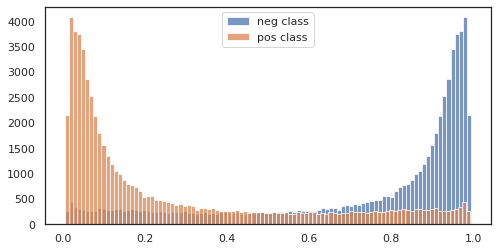

In [130]:
plt.figure(figsize=(8,4))
plt.hist(pred_proba_class0, bins=100, alpha=0.75, label='neg class')
plt.hist(pred_proba_class1, bins=100, alpha=0.75, label='pos class')
plt.legend()
plt.show()

In [118]:
pred_df = pd.DataFrame(results, columns=["class_0", "class_1"]) 

In [119]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   class_0  60000 non-null  float64
 1   class_1  60000 non-null  float64
dtypes: float64(2)
memory usage: 937.6 KB


In [120]:
pred_df["y_test"]     = y_test.values
pred_df["prediction"] = pred

In [134]:
pred_df.head()s

,class_0,class_1,y_test,prediction
0,0.889344,0.110656,0,0
1,0.951824,0.048176,0,0
2,0.484903,0.515097,0,1
3,0.141256,0.858744,1,1
4,0.855965,0.144035,0,0


In [132]:
pred_df[pred_df["y_test"]==1].head()

,class_0,class_1,y_test,prediction
3,0.141256,0.858744,1,1
6,0.011729,0.988271,1,1
7,0.014458,0.985542,1,1
9,0.794365,0.205635,1,0
16,0.883209,0.116791,1,0


In [131]:
pred_df[pred_df["y_test"]==0].head()

,class_0,class_1,y_test,prediction
0,0.889344,0.110656,0,0
1,0.951824,0.048176,0,0
2,0.484903,0.515097,0,1
4,0.855965,0.144035,0,0
5,0.931587,0.068413,0,0


In [106]:
confusion = confusion_matrix(y_test, pred)
accuracy  = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall    = recall_score(y_test, pred)

In [107]:
print(confusion)

[[41023  3085]
 [ 6159  9733]]


In [110]:
print("Accuracy : {0:.8f}".format(accuracy))
print("Precision: {0:.8f}".format(precision))
print("Recall   : {0:.8f}".format(recall))

Accuracy : 0.84593333
Precision: 0.75932283
Recall   : 0.61244651


(59800,) (59800,) (59799,)


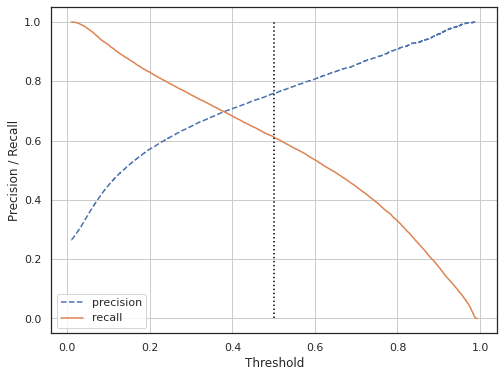

In [154]:
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
print(precisions.shape, recalls.shape, thresholds.shape)

plt.figure(figsize=(8,6))
threshold_boundary = thresholds.shape[0]
plt.plot(thresholds, precisions[0:threshold_boundary], "--", label='precision')
plt.plot(thresholds, recalls[0:threshold_boundary], "-", label='recall')
plt.plot([0.5,0.5], [0.0,1.0], ':', color='black')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.legend()
plt.grid()
plt.show()

In [144]:
auc = roc_auc_score(y_test, pred_proba)
print("AUC: {0:.8f}".format(auc))

AUC: 0.88634196


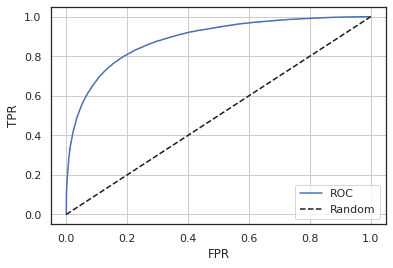

In [161]:
fprs, tprs, thresholds = roc_curve(y_test, pred_proba)

plt.plot(fprs, tprs, label="ROC")
plt.plot([0,1],[0,1], 'k--', label="Random")
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

In [95]:
ftr_imp = pd.DataFrame(lgbm_clf.feature_importances_, index=features, columns=["Feature_Importances"])
ftr_imp.sort_values("Feature_Importances", ascending=False)

,Feature_Importances
cont4,228
cont2,172
cont6,169
cont5,166
cat10,162
cont1,153
cat8,151
cat1,148
cat7,139
cont3,132


<AxesSubplot:xlabel='Feature_Importances'>

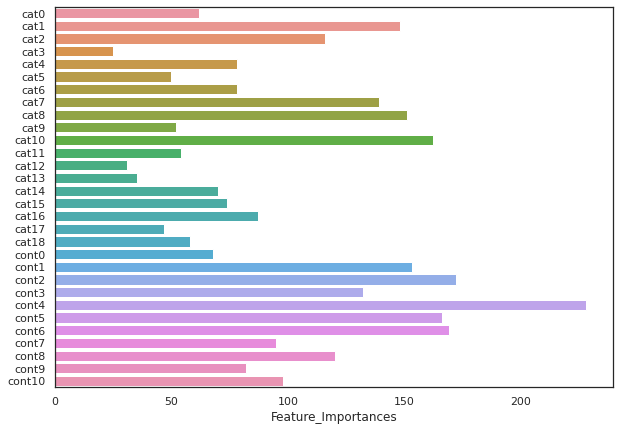

In [143]:
plt.figure(figsize=(10,7))
sns.barplot("Feature_Importances", features, data=ftr_imp)